In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e1_general_model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_received_signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [3]:
num_samples=10

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(A, y, N, sig2e, Tau_p, loc, max_iter=1000, stopping_criterion=1e-4):
    # Correlation Aware Sparse Bayesian Learning (sbl) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
        # Compute inverse of Gamma
        Gamma_inv = np.linalg.solve(Gamma, np.eye(Gamma.shape[0]))

        # Compute posterior covariance and mean
        Sigma_x_inv = (1/sig2e) * A.conj().T @ A + Gamma_inv  # Inverse covariance matrix

        # Use np.linalg.solve instead of pinv
        Sigma_x = np.linalg.solve(Sigma_x_inv, np.eye(Sigma_x_inv.shape[0]))  # Solve linear system for covariance matrix
        mu_x = (1/sig2e) * Sigma_x @ A.conj().T @ y  # Posterior mean

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for sbl results
z_sbl = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # sbl results
gamma_sbl = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # sbl gamma values
hit_rate_sbl = np.zeros((num_samples, len(snr_db_array)))  # Hit rate for sbl
miss_detection_rate_sbl = np.zeros((num_samples, len(snr_db_array)))  # Miss detection rate for sbl
false_alarm_rate_sbl = np.zeros((num_samples, len(snr_db_array)))  # False alarm rate for sbl
norm_mse_sbl = np.zeros((num_samples, len(snr_db_array)))  # Norm MSE for sbl

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply sbl algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_sbl[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_sbl[sample_index, snr_db_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for sbl
        hit_rate_sbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the miss detection rate for sbl
        miss_detection_rate_sbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 0) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the false alarm rate for sbl
        false_alarm_rate_sbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for sbl
        norm_mse_sbl[sample_index, snr_db_index] = (
            np.linalg.norm(z - z_result)**2 / max(1e-10, np.linalg.norm(z)**2)
        )


Processing Samples:  20%|██        | 2/10 [12:59<51:58, 389.85s/it]

Converged after 945 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [04:58<00:56, 56.49s/it]

Converged after 648 iterations



Processing Samples:  40%|████      | 4/10 [25:27<37:40, 376.74s/it]

Converged after 819 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [05:11<01:01, 61.06s/it]

Converged after 871 iterations



Processing SNR Levels:  50%|█████     | 3/6 [03:08<03:09, 63.04s/it]

Converged after 999 iterations



Processing Samples:  60%|██████    | 6/10 [37:58<25:03, 375.97s/it]

Converged after 932 iterations



Processing Samples:  70%|███████   | 7/10 [44:18<18:51, 377.25s/it]

Converged after 841 iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [04:11<02:03, 61.84s/it]

Converged after 934 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [05:12<01:01, 61.68s/it]

Converged after 950 iterations



Processing Samples:  90%|█████████ | 9/10 [56:47<06:14, 374.39s/it]

Converged after 753 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [05:22<01:03, 63.95s/it]

Converged after 902 iterations



Processing Samples: 100%|██████████| 10/10 [1:03:09<00:00, 378.94s/it]

Converged after 898 iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hit_rate_sbl = np.mean(hit_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_miss_detection_rate_sbl = np.mean(miss_detection_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_sbl = np.mean(false_alarm_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_sbl = np.mean(norm_mse_sbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_sbl)
print("Average Miss Detection Rate across samples per SNR level:", avg_miss_detection_rate_sbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_sbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_sbl)

Average Hit Rate across samples per SNR level: [31. 56. 73. 90. 97. 98.]
Average Miss Detection Rate across samples per SNR level: [69. 44. 27. 10.  3.  2.]
Average False Alarm Rate across samples per SNR level: [2.92307692 2.35897436 1.92307692 0.92307692 0.25641026 0.1025641 ]
Average Normalized MSE across samples per SNR level: [1.09578751 0.81209792 0.4595798  0.23125036 0.08258076 0.04330279]


In [8]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/e1_results_sbl_snr_db.npz',
                    z_sbl=z_sbl,
                    gamma_sbl=gamma_sbl,
                    hit_rate_sbl=hit_rate_sbl,
                    miss_detection_rate_sbl=miss_detection_rate_sbl,
                    false_alarm_rate_sbl=false_alarm_rate_sbl,
                    norm_mse_sbl=norm_mse_sbl,
                    avg_hit_rate_sbl=avg_hit_rate_sbl,
                    avg_miss_detection_rate_sbl=avg_miss_detection_rate_sbl,
                    avg_false_alarm_rate_sbl=avg_false_alarm_rate_sbl,
                    avg_norm_mse_sbl=avg_norm_mse_sbl,
                    pilot_length=pilot_length,
                    snr_db_array=snr_db_array)

print("All results have been saved")

All results have been saved


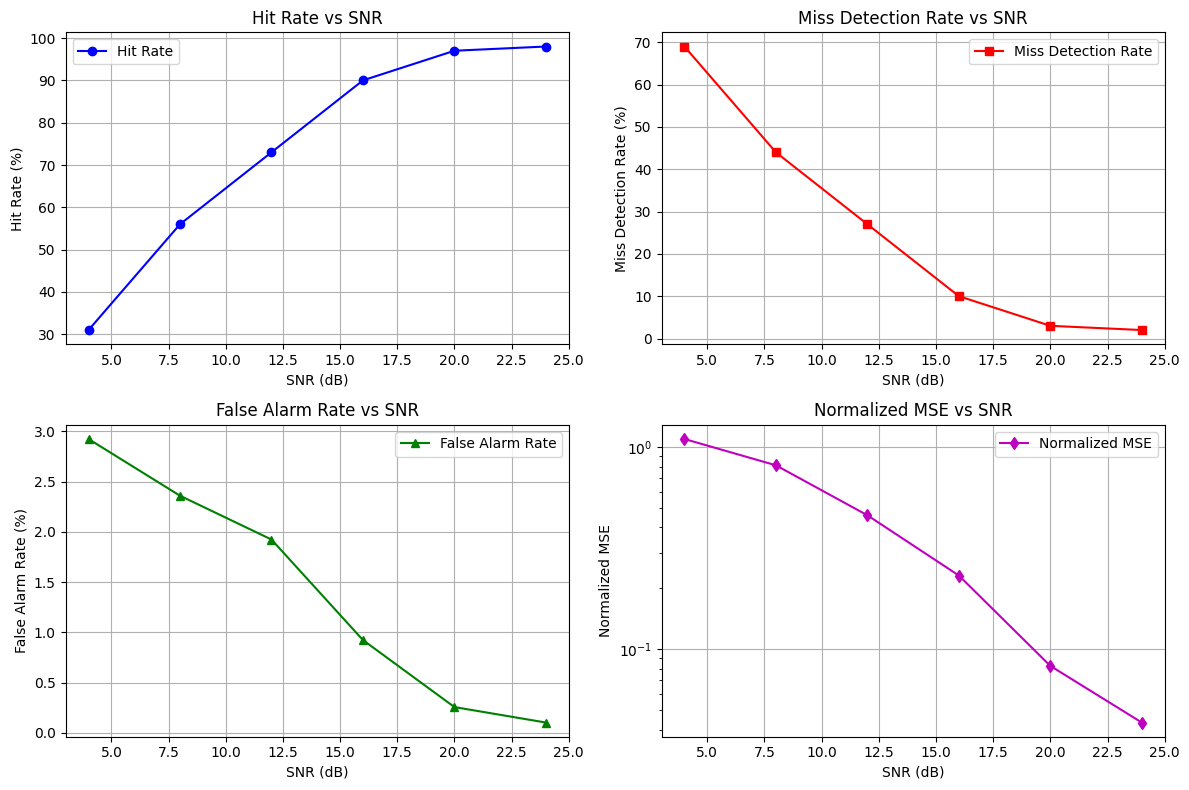

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(snr_values, avg_hit_rate_sbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(snr_values, avg_miss_detection_rate_sbl, marker='s', linestyle='-', color='r', label='Miss Detection Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Miss Detection Rate (%)")
plt.title("Miss Detection Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(snr_values, avg_false_alarm_rate_sbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(snr_values, avg_norm_mse_sbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sbl_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

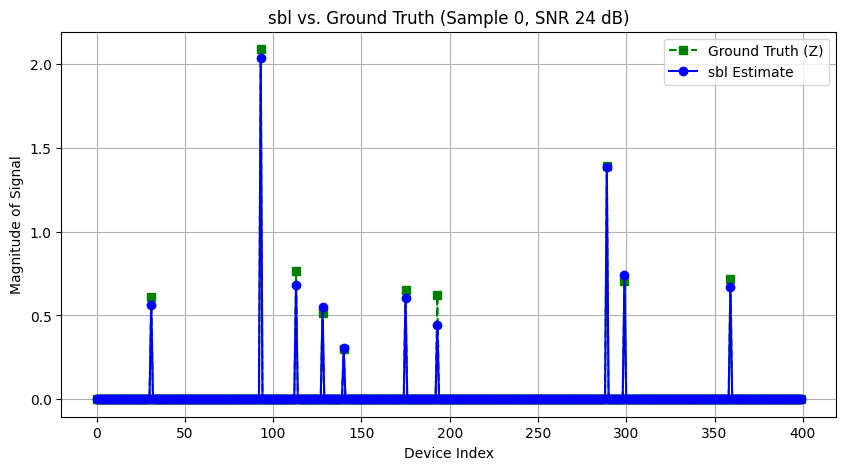

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_sbl_vs_ground_truth(z_sbl, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_sbl_vs_ground_truth(gamma_sbl, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_sbl[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


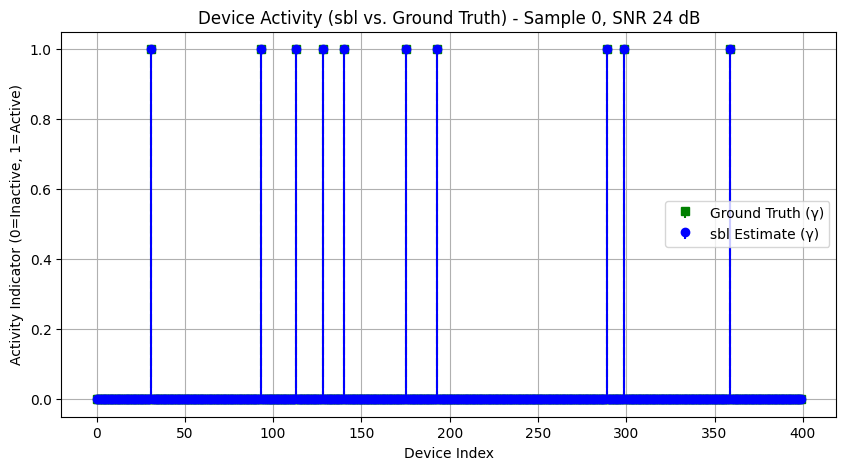

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_sbl_vs_ground_truth(gamma_sbl, all_gamma, sample_index, snr_index, snr_value)